In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import os

In [2]:
# Function that traverse through given directory and for every directory returns 
# lists of image and the corresponding emotion

def load_data(data_path):

    data_dir_list = os.listdir(data_path)

    img_data_list = []
    img_label_list = []

    # Traverse through each folder
    for dataset in data_dir_list:
        if os.path.isdir(data_path + '/' +  dataset):
            img_list=os.listdir(data_path+'/'+ dataset)
            
            # Resize each image
            for img in img_list:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )

                # Convert image to grayscale
                input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                
                input_img_resize=cv2.resize(input_img_gray,(48,48))
                img_data_list.append(input_img_resize)
                img_label_list.append(dataset)
                
    img_data = np.array(img_data_list)
    img_labels = np.array(img_label_list)

    return img_data, img_labels

In [3]:
image_data, image_labels=load_data('./datasets/ck+/')
print(image_data.shape)
print(image_labels.shape)
for i in range(50,60):
    print(image_labels[i])

(327, 48, 48)
(327,)
surprise
surprise
surprise
surprise
surprise
surprise
surprise
surprise
surprise
surprise


In [4]:
# Normalize the pixel values to the range [0, 1]

def normalize_data(data):

    return data.astype('float32') / 255.0

In [5]:
# Because faces should be symetrical, but they aren't perfectly symetric, one possible way to make more data is
# to add mirrored images of faces. In this way, we are doubling instances of classes. We can exclude some classes
# from being processed this way 

    
def add_mirror_images(images, labels, exclude = []):
    
    all_images_list = []
    all_labels_list = []
    n = len(images)
    
    for i in range(n):
        
        all_images_list.append(images[i])
        all_labels_list.append(labels[i])
        
        # Don't perform mirroring if label is set to excluded
        if labels[i] not in exclude:
            # Mirror the image horizontally
            mirrored_image = cv2.flip(images[i], 1)
            all_images_list.append(mirrored_image)
            all_labels_list.append(labels[i]) 
        
    all_images = np.array(all_images_list)
    all_labels = np.array(all_labels_list)
    
    return all_images, all_labels 

In [6]:
# Assuming 'image' is your 48x48 image with values between 0 and 1

def plot_image(image, label):
    plt.imshow(image, cmap='gray') 
    plt.axis('off')  
    plt.show()
    print(label)

In [7]:
# Function for making Bar plot which shows count of every emotion in alphabetical order

def plot_count(images, labels):
    
    labels_set = set(labels)
    label_counts = {}
    
    for label in labels_set:
        label_counts[label] = 0
    
    for label in labels_set:
        for i in range(len(images)):
            if (labels[i] == label):
                label_counts[label] += 1
    
    # Sort dictionary in order to make same bar plot every time
    sorted_label_keys = sorted(label_counts.keys())
    sorted_label_counts = {key: label_counts[key] for key in sorted_label_keys}
    
    # Create a bar plot
    plt.figure(figsize=(10, 6)) 
    plt.bar(sorted_label_counts.keys(), sorted_label_counts.values(), color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Emotion Count')
    plt.xticks(rotation=45) 
    
    # Display the counts above each bar
    for i, count in enumerate(sorted_label_counts.values()):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [8]:
# Function which will delete random instances from images if they exceed the number upto

def _decrease_bigger_indexes(target_images_indexes, random_index):
    for i in range(len(target_images_indexes)):
        if target_images_indexes[i] > random_index:
            target_images_indexes[i] -= 1
            
    return target_images_indexes    
    
def random_delete_upto(images, labels, target_label, upto, seed = None):
    
    # Set seed
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        
    target_images_indexes = []
    data_images = images
    data_labels = labels
    
    # Finding all target images
    for i in range(len(images)):
        if target_label == labels[i]:
            target_images_indexes.append(i)
            
         
    # Randomly deleting images and corresponsive labels
    n = len(target_images_indexes)
    while upto < n:
        random_index = random.choice(target_images_indexes)
        target_images_indexes.remove(random_index)
        data_images = np.delete(data_images, random_index, axis=0)
        data_labels = np.delete(data_labels, random_index, axis=0)
        target_images_indexes = _decrease_bigger_indexes(target_images_indexes, random_index)
        n -= 1

    return data_images, data_labels

In [9]:
def generate_report(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy = accuracy_score(y_test, y_pred)
    
    class_report = classification_report(y_test, y_pred)
    
    print("Confusion matrix: \n", conf_matrix,
         "\nF1 score: \n", f1,
         "\nAccuracy: \n", accuracy,
         "\nClassification report: \n", class_report)

In [10]:
# Libraries for showing lbp_example

from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

In [11]:
def compute_lbp(image, radius=1):

    points = 8 * radius

    # Compute LBP features
    lbp_image = feature.local_binary_pattern(image, P=points, R=radius, method="nri_uniform")
    n_bins = int(lbp_image.max() + 1)
    lbp_histogram, _ = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins))

    # Normalize LBP histogram
    lbp_histogram = lbp_histogram.astype("float")
    lbp_histogram /= (lbp_histogram.sum() + 1e-6)
    
    return lbp_histogram

In [12]:
def plot_lbp_hist(lbp_histogram):
    
    # Create a range for the x-axis (bin numbers)
    bins = np.arange(len(lbp_histogram))

    # Create a bar plot of the LBP histogram
    plt.bar(bins, lbp_histogram, width=1, align='center')

    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    plt.title('LBP Histogram')

    plt.show()

In [13]:
def _overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def _highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')



def _hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
def plot_lbp_example(image, radius=1):
    
    points = 8 * radius
    
    lbp = local_binary_pattern(image, points, radius, method="uniform")

    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(points // 2 - w, points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(points - w, points + 2))
    i_14 = points // 4            # 1/4th of the histogram
    i_34 = 3 * (points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(_overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = _hist(ax, lbp)
        _highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')

In [14]:
ROWS = 48
COLS = 48
NUM_OF_CHANNELS = 3
NUM_OF_CLASSES = 7

In [15]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


2023-09-14 12:25:00.696791: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 12:25:00.721727: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:25:00.878165: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:25:00.878949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:25:01.535236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [16]:

from sklearn.model_selection import train_test_split
# Da bismo dobili sve jedinstvene vrednosti liste y_stratify koristimo klasu Counter iz paketa
# collections
from collections import Counter


In [17]:
print('Hi there!')

#Alexnet arhitektura

alexnet_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu', input_shape=(ROWS, COLS, 1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(2304, activation='relu'),
    Dropout(0.5),
    Dense(2304, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax')
])

Hi there!


2023-09-14 12:25:05.720070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 12:25:05.722218: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [152]:
#alexnet_model.summary()

In [18]:
EPOCHS = 50
BATCH_SIZE = 128

In [19]:
# Treniramo model
#history = alexnet_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

(327, 48, 48)
(327,)
(327, 48, 48)
(654, 48, 48)
(654,)
contempt


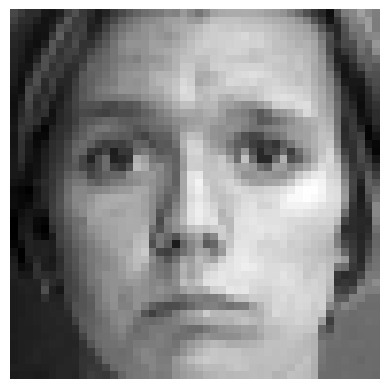

contempt
------------------------------------------------
New stage!


In [20]:
image_data, image_labels=load_data('./datasets/ck+/')
print(image_data.shape)
print(image_labels.shape)
#for i in range(50,60):
#    print(image_labels[i])
image_data=normalize_data(image_data)
print(image_data.shape)
all_images, all_labels=add_mirror_images(image_data, image_labels)
print(all_images.shape)
print(all_labels.shape)
print(all_labels[0])
plot_image(all_images[0], all_labels[0])
print('------------------------------------------------')
print('New stage!')
#plot_count(all_images, all_labels)

In [21]:
print("Splitting data into train, test and validation sets...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
            all_images, all_labels, test_size=0.15, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.15, random_state=7)

Splitting data into train, test and validation sets...


In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
X_train[0].ndim

(471, 48, 48)
(99, 48, 48)
(471,)


2

In [23]:
#Treniramo model
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history = alexnet_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/50


ValueError: in user code:

    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [24]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam




from tensorflow.keras import utils
from tensorflow.keras import backend as K


In [64]:
np.random.seed(7)
number_of_classes=7

#y_train = utils.to_categorical(y_train, number_of_classes)
#y_test = utils.to_categorical(y_test, number_of_classes)
print(y_train.shape)
print(y_train.astype)
print(y_train[0])
#y_train_help=np.array((471, 7))
y_train_help=[]
for image in y_train:
    if image=='anger':
        #print('Hi there!')
        y_train_help=[1,0,0,0,0,0,0]
    if image=='contempt':
        y_train_help=[0,1,0,0,0,0,0]
    if image=='disgust':
        y_train_help=[0,0,1,0,0,0,0]
    if image=='fear':
        y_train_help=[0,0,0,1,0,0,0]
    if image=='happy':
        y_train_help=[0,0,0,0,1,0,0]
    if image=='sadness':
        y_train_help=[0,0,0,0,0,1,0]
    if image=='surprise':
        y_train_help=[0,0,0,0,0,0,1]
    image=y_train_help       
        
print(y_train.shape)
print(y_train[0])
#np.

(471,)
<built-in method astype of numpy.ndarray object at 0x7fe0c40d9750>
happy
(471,)
happy


In [76]:
input_shape=(48,48,1)
model = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])


In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 1)         10        
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 36864)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               4718720   
                                                      

In [78]:
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


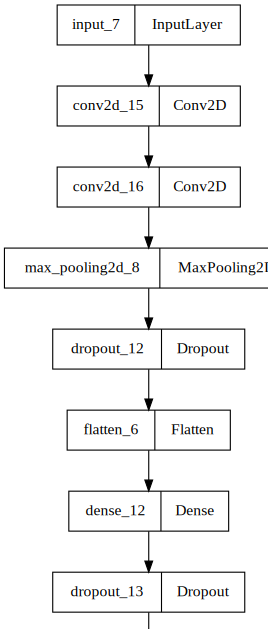

In [79]:
display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))

In [80]:
model.compile(loss=accuracy_score,optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [81]:
batch_size = 128
epochs = 30

In [82]:
print(X_train.shape)
print(y_train.shape)
print(X_train[0])

(471, 48, 48)
(471,)
[[0.3372549  0.3372549  0.3254902  ... 0.0627451  0.07843138 0.26666668]
 [0.33333334 0.3372549  0.2784314  ... 0.07843138 0.03921569 0.15294118]
 [0.3372549  0.34117648 0.22352941 ... 0.09411765 0.06666667 0.08235294]
 ...
 [0.2509804  0.25490198 0.25882354 ... 0.14509805 0.18039216 0.2509804 ]
 [0.24705882 0.24705882 0.2509804  ... 0.13725491 0.18431373 0.24313726]
 [0.24313726 0.24705882 0.25490198 ... 0.14117648 0.2        0.2627451 ]]


In [83]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/30


NotImplementedError: in user code:

    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 169, in wrapper  *
        return func(*args, **kwargs)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 221, in accuracy_score  *
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 86, in _check_targets  *
        check_consistent_length(y_true, y_pred)
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 395, in check_consistent_length  *
        uniques = np.unique(lengths)
    File "<__array_function__ internals>", line 180, in unique  **
        
    File "/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py", line 272, in unique
        ar = np.asanyarray(ar)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (accuracy_score/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
